## Setup experiment

### Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2

### Requirements Installation (Only for the First run)

!pip install wandb
!pip install datasets
!pip install transformers
!pip install trl
!pip install sentencepiece
!pip install portalocker>=2.0.0
!pip install sacremoses
!pip install sacrebleu
!pip install xformers

In [2]:
import random
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
tqdm.pandas()
from PIL import Image

from datasets import load_dataset
from functools import partial

from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, pipeline, ViltProcessor, ViltForImageAndTextRetrieval, T5Tokenizer, T5ForConditionalGeneration

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model, AutoModelForSeq2SeqLMWithValueHead



### Configuration

In [4]:

config = PPOConfig(
    model_name="Helsinki-NLP/opus-mt-de-en",
    steps=3625, # 29000/8 (size of the dataset/ batch size)
    batch_size=8,
    learning_rate=1e-4,
    remove_unused_columns=False,
    log_with="wandb"
)

seed = 42

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [5]:
np.random.seed(seed)

In [6]:
29000/8

3625.0

## Load data and models

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [7]:
opus_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(config.model_name)

opus_model_ref = create_reference_model(opus_model)

opus_tokenizer = AutoTokenizer.from_pretrained(config.model_name)

opus_tokenizer.pad_token = opus_tokenizer.eos_token

### Load Multi30K dataset
Description

! git clone https://github.com/multi30k/dataset.git

In [8]:
## Zipped Images corresponding to the textual dataset
data_path = "./flickr30k-images"

def get_multi30k(from_lang:str="de", to_lang:str="en", split:str="train"):
  ## Testing file has a different name hence this condition
  if split != "test":
    with open(f"./dataset/data/task1/tok/{split}.lc.norm.tok.{from_lang}") as from_file, open(f"./dataset/data/task1/tok/{split}.lc.norm.tok.{to_lang}") as to_file, open(f"./dataset/data/task1/image_splits/{split}.txt", 'r') as img_split:
      image_split = img_split.read()
      image_split = image_split.split("\n")
      dataset = list(zip(image_split, from_file.readlines(), to_file.readlines()))
      print("size of the dataset: ",len(dataset))
  else:
    ## Train and val file names have similar structure
    with open(f"./dataset/data/task1/tok/{split}_2018_flickr.lc.norm.tok.{from_lang}") as from_file, open(f"./dataset/data/task1/tok/{split}_2018_flickr.lc.norm.tok.{to_lang}") as to_file, open(f"./dataset/data/task1/image_splits/{split}_2018_flickr.txt", 'r') as img_split:
      image_split = img_split.read()
      image_split = image_split.split("\n")
      dataset = list(zip(image_split, from_file.readlines(), to_file.readlines()))

  dataset = list(map(lambda x: {"image":x[0],"from":x[1][:-3],"to":x[2][:-3]}, dataset))  ## Removing '\n' from the end of each sentence
  return dataset

train_dataset = get_multi30k()
train_dataset[0]

size of the dataset:  29000


{'image': '1000092795.jpg',
 'from': 'zwei junge weiße männer sind im freien in der nähe vieler büsche',
 'to': 'two young , white males are outside near many bushes'}

!tar -xf ./flickr30k-images.tar.gz

two young , white males are outside near many bushes


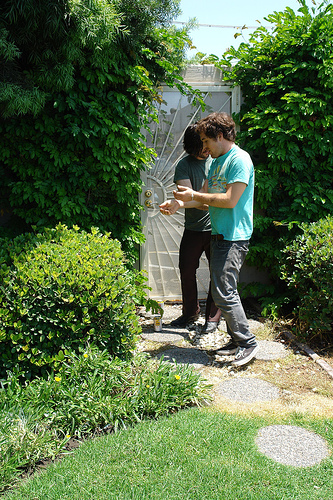

In [9]:
print(train_dataset[0]["to"])
Image.open(f'{data_path}/{train_dataset[0]["image"]}')

### Tokenize from_lang

We tokenize all IMDB in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first `txt_in_len` tokens. In a second step we decode these tokens back to text for later display.

In [10]:
def up_dataset(line):
  line["input_ids"] = torch.tensor(opus_tokenizer.encode(line['from'], max_length=25,truncation=True),dtype=torch.int)
  line["query"] = opus_tokenizer.decode(line["input_ids"]) ## In this case, 'query' is same as 'from'
  return line

In [11]:
dataset = tuple(map(up_dataset, train_dataset))
print(dataset[0])

{'image': '1000092795.jpg', 'from': 'zwei junge weiße männer sind im freien in der nähe vieler büsche', 'to': 'two young , white males are outside near many bushes', 'input_ids': tensor([  338,  5338, 17270,    17, 28237,    70,    49,  6017,     5,     9,
           17, 21108, 10949,    17, 10585,  3351,     0], dtype=torch.int32), 'query': '▁zwei▁junge▁weiße männer▁sind im▁freien in der nähe▁vieler büsche</s>'}


In [51]:
class Multi30KDataset(Dataset):
  def __init__(self, dataset):
    super()
    self.image_path = dataset["image"]
    self.from_lang = dataset["from"]
    self.to_lang = dataset["to"]
    self.input_ids = dataset["input_ids"]
    self.query = dataset["query"]

  def __len__(self):
    return len(self.query)

  def __getitem__(self, idx):
    from_lang = self.from_lang[idx]
    to_lang = self.to_lang[idx]
    input_ids = self.input_ids[idx]
    query = self.query[idx]
    image_path = self.image_path[idx]
    sample = {"image": image_path, "from":from_lang, "to": to_lang,"input_ids":input_ids, "query":query}
    return sample

In [52]:
df = pd.DataFrame(dataset)
dataset = Multi30KDataset(df)
# dataset = DataLoader(dataset, batch_size=1)

In [53]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

d46f77a748bc4f3a114ad497addc65f7fa3cfa65

In [14]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grey8magic (gargeya). Use `wandb login --relogin` to force relogin


True

In [35]:
ppo_trainer = PPOTrainer(config, opus_model, opus_model_ref, opus_tokenizer, dataset, data_collator=collator)

env/reward,▄▇▆█▁▆▇▃▆▄▃▂▃▄█▇▆▅▂▆▄▂█▅▆▇▄▆▄▆▅▇▃▆▇▄▆▃▆▃
env/reward_mean,▄▇▆█▁▆▇▃▆▄▃▂▃▄█▇▆▅▂▆▄▂█▅▆▇▄▆▄▆▅▇▃▆▇▄▆▃▆▃
env/reward_std,█▄▆▂▅▄▄▆▃▆▅▃▆▄▂▅▁▅▆▂▃▄▃▂▄▃▆▃▆▃▅▃▇▃▃▂▃█▅▁
objective/entropy,▁▁▁▁▁▁▁▂▂▂█▄▂▃▄▃▃▃▃▆▃▂▂▂▃▂▃▄▃▃▂▃▄▃▄▃▇▃▃▂
objective/kl,▆▇▇▆█▆█▅▆▆▁▃▄▅▂▃▃▄▂▂▄▅▅▅▄▆▃▂▅▄▆▄▂▃▃▅▂▃▅▄
objective/kl_coef,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
ppo/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ppo/loss/policy,▆▇▆▆▆▆▆▆▆▆▃▆▆▆▅▆▅▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆█▆▅▆▁▆▆▆
ppo/loss/total,█▄▆▄▆▅▆▅▃▅▃▂▅▃▂▄▁▄▅▂▃▄▄▃▆▄▅▃▆▄▆▄▆▄▃▄▃▇▇▂
ppo/loss/value,█▄▆▄▆▅▆▅▃▅▃▂▅▃▂▄▁▄▅▂▃▄▄▃▆▄▅▃▆▄▆▄▆▄▃▄▃▇▇▂
ppo/mean_non_score_reward,▅▄▄▅▃▄▃▅▄▄█▇▅▄▇▆▆▅▆▇▄▃▃▄▄▂▄▆▃▃▁▃▅▄▄▂▅▃▁▂


### Load ViLT classifier
We load a ViLT model for visual reasoning.

In [16]:
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu" # to avoid a `pipeline` bug
else:
    device = ppo_trainer.accelerator.device

In [17]:
device

0

Use of **ViLT's Visual Reasoning** for Reward Calculation

In [18]:
## Reward Function using Visual BERT for Visual Reasoning score to pass for the model training

def load_vilt():
  processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-coco", device=device)
  vilt_model = ViltForImageAndTextRetrieval.from_pretrained("dandelin/vilt-b32-finetuned-coco")
  return processor, vilt_model

vilt_processor, vilt_model = load_vilt()
def get_rewards_from_vilt(image_path, target_desc, processor=vilt_processor, vilt_model = vilt_model):
  image_path = f"./flickr30k-images/{image_path}"
  image = Image.open(image_path)
  text = target_desc

  # forward pass
  encoding = processor(image, text, return_tensors="pt")
  outputs = vilt_model(**encoding)
  score = outputs.logits[0, :].item()
  # if score < -2:
  #   return torch.tensor(-2.0)
  # elif score < 5:
  #   return torch.tensor(0.3)
  # else:
  #   return torch.tensor(2.03)
  return torch.tensor(round(score, 2)) #score

def get_rewards(image_batch, target_batch):
  rewards = []
  for image_path, target_desc in zip(image_batch, target_batch):
    rewards.append(get_rewards_from_vilt(image_path, target_desc))
  return rewards

In [19]:
get_rewards(["10002456.jpg"], ["several men in hard hats are operating a giant pulley system ."])

[tensor(4.9500)]

Reward:  tensor(4.9500)


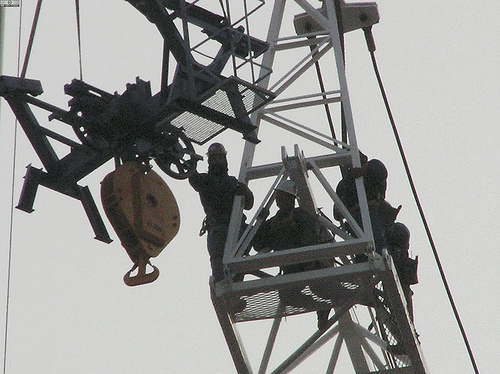

In [20]:
sample_path = "10002456.jpg"
sample_desc = "several men in hard hats are operating a giant pulley system ."

reward = get_rewards_from_vilt(image_path=sample_path, target_desc=sample_desc)
print("Reward: ",reward)
sample_path = f"./flickr30k-images/{sample_path}"
Image.open(sample_path)

Reward:  tensor(-11.1400)


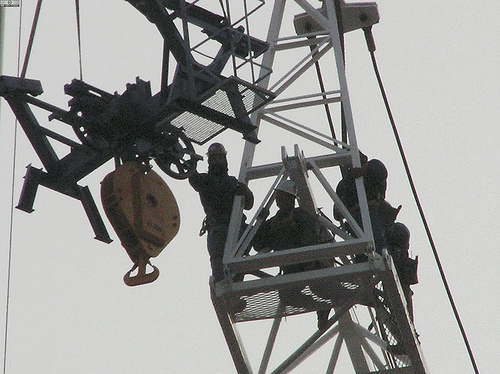

In [21]:
# False Negative Example

sample_path = "10002456.jpg"
sample_desc = "A camel is drinking water in a dessert"

reward = get_rewards_from_vilt(image_path=sample_path, target_desc=sample_desc)
print("Reward: ",reward)
sample_path = f"./flickr30k-images/{sample_path}"
Image.open(sample_path)

Reward:  tensor(5.4300)


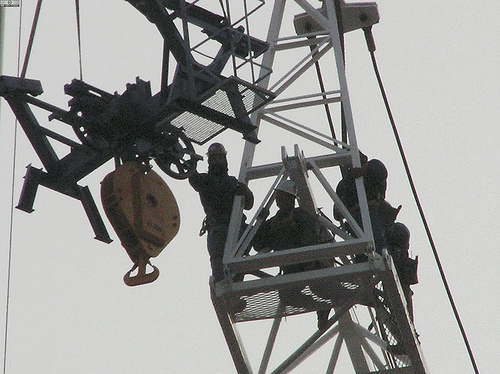

In [22]:
# Hilarious Example I came across while showing a negative reward! Hahahah!!!!

## The reward is higher than that of the original prompt.

sample_path = "10002456.jpg"
sample_desc = "A turbine working in the sea with few penguins around it."

reward = get_rewards_from_vilt(image_path=sample_path, target_desc=sample_desc)
print("Reward: ",reward)
sample_path = f"./flickr30k-images/{sample_path}"
Image.open(sample_path)

### Reward function

### Generation settings

In [23]:
generation_kwargs = {
    "min_length":-1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": opus_tokenizer.eos_token_id,
    "max_new_tokens": 24, # 25-1
    "eos_token_id": -1
}


## Optimize model

**Steps**

The training loop consists of the following steps:
1. Get a batch of queries and create random controls
2. Get the query responses from the policy
3. Join query and responses and tokenize for BERT analysis
4. Get sentiments for query/responses from BERT
5. Optimize policy with PPO using the (query, response, reward) triplet
6. Log all the training statistics

**Training time**

This step takes **~2h** on a P6000 GPU with the above specified settings.

In [24]:
print(device)

0


In [31]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-de-en")

In [ ]:
for epoch in range(1):
    for batch in tqdm(ppo_trainer.dataloader):
        logs, game_data,  = dict(), dict()

        game_data['query'] = batch["query"]    
        query_tensors = batch["input_ids"]  
        #### get response from Opus
        response_tensors = []
        for query in query_tensors:
            response = ppo_trainer.generate(query, **generation_kwargs)
            response_tensors.append(response.squeeze())
#         print(len(response_tensors), len(response_tensors[0]))
        translated = translator(batch['query'])
        game_data['response'] = list(map(lambda x: list(x.values())[0], translated))

        rewards = get_rewards(image_batch=batch["image"], target_batch=game_data['response'])
        
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

        #for cs in ctrl_str:
        key = 'env/reward'
        stats[key] = np.mean([r.cpu().numpy() for r in rewards])
        ppo_trainer.log_stats(stats, game_data, rewards)

 12%|█████████▌                                                                       | 426/3625 [35:38<4:55:44,  5.55s/it]wandb: WARNING Failed to cache /home/ec22146/.local/share/wandb/artifacts/staging/tmpy8zhws3a, ignoring [Errno 24] Too many open files: '/home/ec22146/.cache/wandb/artifacts/obj/md5/92/tmp_2defa95c7a4511f4'
Exception in thread Thread-3649:
Traceback (most recent call last):
  File "/home/ec22146/.local/lib/python3.9/site-packages/wandb/filesync/step_checksum.py", line 85, in _thread_body
    shutil.copy2(req.path, path)
  File "/usr/lib64/python3.9/shutil.py", line 444, in copy2
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/usr/lib64/python3.9/shutil.py", line 266, in copyfile
    with open(dst, 'wb') as fdst:
OSError: [Errno 24] Too many open files: '/tmp/tmp3vh8ydjhwandb/mpovs03j-media/table/game_log_425_f661fa4cbba3a9101820.table.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fi

## Save model
Finally, we save the model to disk for later usage.

In [33]:
opus_model.eval()
opus_model.save_pretrained('opus-model')
opus_tokenizer.save_pretrained('opus_tokenizer')

('opus_tokenizer/tokenizer_config.json',
 'opus_tokenizer/special_tokens_map.json',
 'opus_tokenizer/vocab.json',
 'opus_tokenizer/source.spm',
 'opus_tokenizer/target.spm',
 'opus_tokenizer/added_tokens.json')

In [12]:
loaded_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained("./opus-model")
loaded_tokenizer = AutoTokenizer.from_pretrained("./opus_tokenizer")

Some weights of the model checkpoint at ./opus-model were not used when initializing MarianMTModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing MarianMTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianMTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Model Inspection

In [13]:
from sacrebleu import corpus_bleu
def bleu_score(li_abs_hyp, li_abs_ref):
    """
    Computes the BLEU score
    :param li_abs_hyp: list of hypothesis abstracts (token strings)
    :param li_abs_ref: list of reference abstracts (token strings)
    """
    bleu = corpus_bleu(li_abs_hyp, [li_abs_ref])

    return bleu.score

In [46]:
loaded_model.eval()
print("Model set for evaluation...")

Model set for evaluation...


In [15]:
import pandas as pd

In [49]:
# df = pd.read_csv("Successful\ training\ attemp\ 1.csv")
df = pd.read_csv("after_full_training_attempt_1.csv", index_col= 0)
df

,image,from,to,input_ids,query,response,reward
0,2664102751.jpg,"ein mann begutachtet den boden , als er vom fa...",a man eyes the ground as he comes in for a lan...,"tensor([ 53, 175, 34, 43, 5576, 138...","ein mann begutachtet den boden,▁als er vom fal...",a man examines the ground when he sets off fro...,6.35
1,2763767621.jpg,männliches kind spielt allein in einem runden ...,male child playing on round contained ride in ...,"tensor([28093, 6, 17, 11847, 4794, 27...",▁männliches kind▁spielt▁allein in▁einem▁runden...,"male child plays alone in a round, closed play...",8.22
2,3350671534.jpg,ein mann fährt auf einer skaterbahn rollschuh,a man rollerblades on a skate course,"tensor([ 53, 175, 34, 15646, 37, ...",ein mann▁fährt auf▁einer skaterbahn rollschuh</s>,a man rides on a skater,3.01
3,345852737.jpg,eine frau in einem burgunderroten mantel verlä...,a woman in a burgundy coat exits trader joe &a...,"tensor([ 50, 17, 14803, 5, 117, ...",eine frau in▁einem burgunderroten mantel▁verlä...,a woman in a burgundy coat leaves trader joe &...,8.49
4,3825750029.jpg,eine frau im blauen oberteil auf einem fahrrad,a woman in a blue tank top riding a bike,"tensor([ 50, 17, 14803, 49, 20421, 6...",eine frau im▁blauen oberteil auf▁einem fahrrad...,a woman in the blue top part on a bike,9.40
5,3896878460.jpg,eine ältere frau schöpft essen aus einer pfanne,an older woman scoops food out of a pan,"tensor([ 50, 15653, 17, 14803, 2425, 87...",eine▁ältere frau schöpft▁essen▁aus▁einer pfann...,an older woman draws food from a pan,7.45
6,4477801634.jpg,ein fotograph mit dreadlocks und anzug macht f...,a dread-locked photographer in a suit takes pi...,"tensor([ 53, 17, 22574, 13544, 30, 7...",ein fotograph mit dreadlocks und anzug▁macht f...,a photographer with dreadlocks and suit takes ...,10.52
7,89787769.jpg,ein mann gießt backteig aus einer silbernen sc...,a man pours batter out of a silver bowl,"tensor([ 53, 175, 34, 17, 32959, ...",ein mann gießt backteig▁aus▁einer▁silbernen sc...,a man pours baking dough from a silver bowl,7.16


### Bleu Score of Trained model

In [29]:
bleu_score(df['response'].tolist(), df["to"].tolist())

22.834615359945317

### Bleu Score of Pretrained Opus model

Using 'query' column in the translator, showed that the Bleu scores are exactly the same for the pretrained and the after-trained model. which implies that the model didn't learn anything or I aam not able to use the trained model. 

In [34]:
translated = translator(df['query'].tolist())
output_text = list(map(lambda x: list(x.values())[0], translated))

In [35]:
bleu_score(output_text, df['to'].tolist())

22.834615359945317

Using the "from" column inside the translator, I get better results: higher bleu score

In [50]:
translated = translator(df['from'].tolist())
output_text = list(map(lambda x: list(x.values())[0], translated))
bleu_score(output_text, df['to'].tolist())

30.43212530100516